In [1]:
# importing packages we'll need
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the data set
df = pd.read_csv('loan.csv', dtype = {'issue_d': str}, low_memory=False)
# https://www.kaggle.com/wendykan/lending-club-loan-data

## Data Exploration

In order to begin to understand our data, let's take a look at the summary statistics for the dollar amounts of these loans.

In [3]:
df.loan_amnt.describe()
# getting summary statistics

count    1.048575e+06
mean     1.538487e+04
std      9.533838e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.300000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

<br>
<br>
The first thing to note is that Lending Club facilitated an amazing 1,048,575 loans over this period! Apparently a lot of people are comfortable investing in these loans. It appears that the range of allowable loan sizes is \$1,000-\$40,000. The mean loan size of \$15,385 looks to be representative of a typical loan based on the 25th, 50th, and 75th percentile values. It looks like loan sizes are more common towards the lower end of the acceptable range, but let's check for sure.
<br>
<br>
<br>

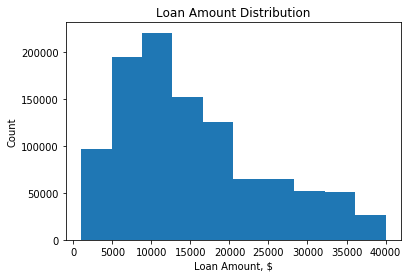

In [4]:
# creating a histogram
plt.hist(df.loan_amnt)
plt.title('Loan Amount Distribution')
plt.ylabel('Count')
plt.xlabel('Loan Amount, $')
plt.show()

We were right, there are definitely more loans toward the lower end of the range. In fact, it looks as though loan sizes follow a gamma distribution. Let's construct a q-q plot to see if this is, in fact, a gamma distribution.
<br>

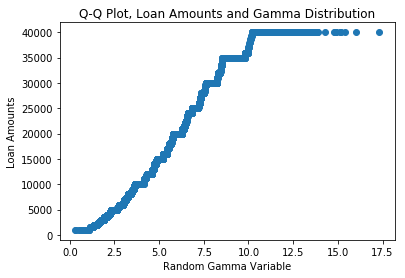

In [5]:
q = np.random.gamma(5, 1, 1048575) # generating a random gamma distribution
q10000 = np.random.choice(q, 10000) # taking 10000 instances
q10000.sort() # sorting for q-q plot
loan_amts = list(df.loan_amnt)
loan_amts10000 = np.random.choice(loan_amts, 10000) # taking 10000 instances
loan_amts10000.sort()# sorting for q-q plot
plt.scatter(x=q10000, y=loan_amts10000)
plt.ylabel('Loan Amounts')
plt.xlabel('Random Gamma Variable')
plt.title('Q-Q Plot, Loan Amounts and Gamma Distribution')
plt.show()

It looks like much of the data follows a rough gamma distribution, except the tail is too fat to truly be considered a gamma distribution.
<br>
<br>
The whole point of investing is to get a return. Are the returns for investors worthwhile?
<br>
<br>

In [6]:
df.int_rate.describe()

count    1.048575e+06
mean     1.280290e+01
std      4.962779e+00
min      5.310000e+00
25%      9.160000e+00
50%      1.199000e+01
75%      1.549000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

<br>
The interest rates on these loans range from 5.31% to an eye-popping 30.99%. It looks like there is potential to make some serious cash here. But wait, what if the rate of 30.99% is an extreme outlier? Let's take a look at the distibution to get a better idea of what to expect.
<br>
<br>

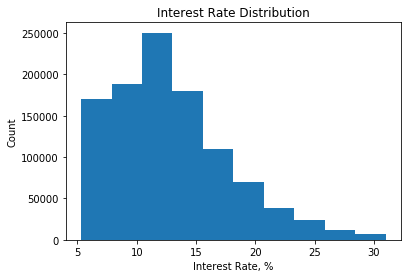

In [7]:
plt.hist(df.int_rate)
plt.title('Interest Rate Distribution')
plt.ylabel('Count')
plt.xlabel('Interest Rate, %')
plt.show()

<br>
Great! Although we ought not expect a 30% return, it looks like double-digit returns are very common. Finally, let's see how long our money would be tied up in one of these loans.
<br><br>

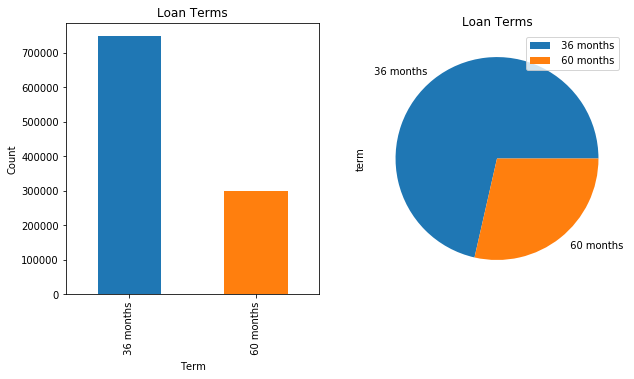

In [8]:
plt.figure(figsize=(10, 5)) #making a subplot

plt.subplot(1, 2, 1)
df.term.value_counts().plot(kind='bar')
plt.title('Loan Terms')
plt.ylabel('Count')
plt.xlabel('Term')

plt.subplot(1, 2, 2)
df.term.value_counts().plot(kind='pie')
plt.title('Loan Terms')
plt.legend()
plt.show()

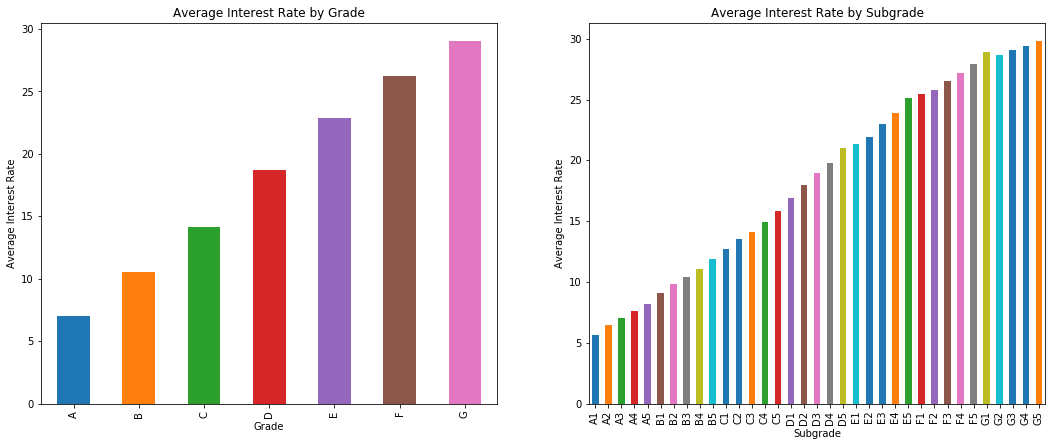

In [9]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
grades = df.groupby('grade') # grouping the data by loan grade
grades.int_rate.mean().plot(kind='bar')
plt.title('Average Interest Rate by Grade')
plt.ylabel('Average Interest Rate')
plt.xlabel('Grade')

plt.subplot(1, 2, 2)
subgrades = df.groupby('sub_grade') # grouping the data by sub-grade
subgrades.int_rate.mean().plot(kind='bar')
plt.title('Average Interest Rate by Subgrade')
plt.ylabel('Average Interest Rate')
plt.xlabel('Subgrade')
plt.show()


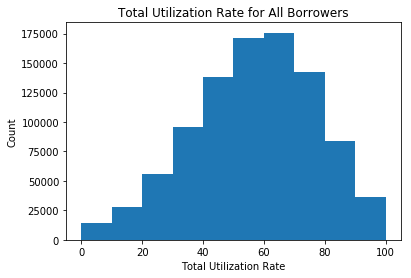

In [10]:
plt.hist(df.all_util, bins=10, range=(0, 100))
plt.title('Total Utilization Rate for All Borrowers')
plt.ylabel('Count')
plt.xlabel('Total Utilization Rate')
plt.show()

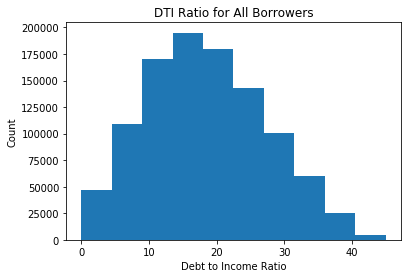

In [11]:

plt.hist(df.dti, bins=10, range=(0, 45))
plt.title('DTI Ratio for All Borrowers')
plt.ylabel('Count')
plt.xlabel('Debt to Income Ratio')
plt.show()

In [12]:
df.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN       2500         2500           2500.0   36 months   
1 NaN        NaN      30000        30000          30000.0   60 months   
2 NaN        NaN       5000         5000           5000.0   36 months   
3 NaN        NaN       4000         4000           4000.0   36 months   
4 NaN        NaN      30000        30000          30000.0   60 months   

   int_rate  installment grade sub_grade       ...        \
0     13.56        84.92     C        C1       ...         
1     18.94       777.23     D        D2       ...         
2     17.97       180.69     D        D1       ...         
3     18.94       146.51     D        D2       ...         
4     16.14       731.78     C        C4       ...         

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   

  disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                Cash                     N                       NaN   
1                Cash                     N                       NaN   
2                Cash                     N                       NaN   
3                Cash                     N                       NaN   
4                Cash                     N                       NaN   

  settlement_status settlement_date settlement_amount  settlement_percentage  \
0               NaN             NaN               NaN                    NaN   
1               NaN             NaN               NaN                    NaN   
2               NaN             NaN               NaN                    NaN   
3               NaN             NaN               NaN                    NaN   
4               NaN             NaN               NaN                    NaN   

  settlement_term  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 145 columns]

In [13]:
list(df)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Columns: 145 entries, id to settlement_term
dtypes: float64(71), int64(38), object(36)
memory usage: 1.1+ GB


We can see that there are 145 columns of data and over 1 million rows, each representing a unique loan. The list of columns is mostly self-explanatory. We can see that 36 of these columns are strings, which means they are likely to be categorical values. The remaining 109 columns are either floats or integers, likely suggesting continuous variables.

In [15]:
df.nunique()

id                                                 0
member_id                                          0
loan_amnt                                       1561
funded_amnt                                     1561
funded_amnt_inv                                 1580
term                                               2
int_rate                                         255
installment                                    69186
grade                                              7
sub_grade                                         35
emp_title                                     233592
emp_length                                        11
home_ownership                                     4
annual_inc                                     52275
verification_status                                3
issue_d                                           27
loan_status                                        7
pymnt_plan                                         2
url                                           

It's interesting to note that there are over 1,500 unique loan amounts, but over 69,000 unique interest rates. The grades (7) and subgrades (35) will probably be the most important categorical features in our model. We can also see that certain columns, such as 'url', are likely to be unimportant since they have 1 or 0 unique values.

In [16]:
df.isnull().sum()*100/df.isnull().count()

id                                            100.000000
member_id                                     100.000000
loan_amnt                                       0.000000
funded_amnt                                     0.000000
funded_amnt_inv                                 0.000000
term                                            0.000000
int_rate                                        0.000000
installment                                     0.000000
grade                                           0.000000
sub_grade                                       0.000000
emp_title                                       8.625420
emp_length                                      7.387645
home_ownership                                  0.000000
annual_inc                                      0.000000
verification_status                             0.000000
issue_d                                         0.000000
loan_status                                     0.000000
pymnt_plan                     

Here we can see what percentage of entries for any given column are null. We will use this information in the data cleaning process prior to building any models.<br> <br> Next, we'll take a look at how the numerical columns correlate with our target, the interest rate.

In [17]:
# filtering for numerical columns only
df_num = df.select_dtypes(exclude=['object'])
df_num.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  int_rate  \
0 NaN        NaN       2500         2500           2500.0     13.56   
1 NaN        NaN      30000        30000          30000.0     18.94   
2 NaN        NaN       5000         5000           5000.0     17.97   
3 NaN        NaN       4000         4000           4000.0     18.94   
4 NaN        NaN      30000        30000          30000.0     16.14   

   installment  annual_inc  url    dti       ...         deferral_term  \
0        84.92     55000.0  NaN  18.24       ...                   NaN   
1       777.23     90000.0  NaN  26.52       ...                   NaN   
2       180.69     59280.0  NaN  10.51       ...                   NaN   
3       146.51     92000.0  NaN  16.74       ...                   NaN   
4       731.78     57250.0  NaN  26.35       ...                   NaN   

   hardship_amount  hardship_length  hardship_dpd  \
0              NaN              NaN           NaN   
1              NaN              NaN           NaN   
2              NaN              NaN           NaN   
3              NaN              NaN           NaN   
4              NaN              NaN           NaN   

   orig_projected_additional_accrued_interest  hardship_payoff_balance_amount  \
0                                         NaN                             NaN   
1                                         NaN                             NaN   
2                                         NaN                             NaN   
3                                         NaN                             NaN   
4                                         NaN                             NaN   

   hardship_last_payment_amount  settlement_amount  settlement_percentage  \
0                           NaN                NaN                    NaN   
1                           NaN                NaN                    NaN   
2                           NaN                NaN                    NaN   
3                           NaN                NaN                    NaN   
4                           NaN                NaN                    NaN   

   settlement_term  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 109 columns]

In [18]:
col_names = list(df_num)

In [19]:
# displaying correlations
for i in col_names:
    print("{} and interest rate correlation is {}".format(i, df_num[i].corr(df_num['int_rate'])))

id and interest rate correlation is nan
member_id and interest rate correlation is nan
loan_amnt and interest rate correlation is 0.06697226362378149
funded_amnt and interest rate correlation is 0.06697357995593946
funded_amnt_inv and interest rate correlation is 0.06694671610251973
int_rate and interest rate correlation is 0.9999999999999998
installment and interest rate correlation is 0.10159058867491691
annual_inc and interest rate correlation is -0.07336469442038507
url and interest rate correlation is nan
dti and interest rate correlation is 0.13085444536568852
delinq_2yrs and interest rate correlation is 0.062226268767203115
inq_last_6mths and interest rate correlation is 0.16274004714640447
mths_since_last_delinq and interest rate correlation is -0.051079784413263
mths_since_last_record and interest rate correlation is -0.018507672738113087
open_acc and interest rate correlation is -0.012564465436055211
pub_rec and interest rate correlation is 0.051749037607456215
revol_bal and 

This is good information, but it is a little difficult to wade through. Let's create a sortable dataframe to more easily understand the correlation relationships.

In [20]:
corr_list = []
for i in col_names:
    corr_list.append(df_num[i].corr(df_num['int_rate']))

In [21]:
new_df = pd.DataFrame()

In [22]:
new_df['term'] = col_names
new_df['corr'] = corr_list
new_df.head()

term      corr
0               id       NaN
1        member_id       NaN
2        loan_amnt  0.066972
3      funded_amnt  0.066974
4  funded_amnt_inv  0.066947

In [23]:
new_df.sort_values(by=['corr'], ascending=False)

term      corr
5                                      int_rate  1.000000
100                             hardship_amount  0.636597
103  orig_projected_additional_accrued_interest  0.627249
24                                total_rec_int  0.373019
106                           settlement_amount  0.337066
104              hardship_payoff_balance_amount  0.294277
47                                     all_util  0.294212
55                                      bc_util  0.265513
93                           sec_app_revol_util  0.261570
82                             percent_bc_gt_75  0.260068
17                                   revol_util  0.247216
33                                    dti_joint  0.226296
105                hardship_last_payment_amount  0.202354
80                           num_tl_op_past_12m  0.174312
52                         acc_open_past_24mths  0.169056
11                               inq_last_6mths  0.162740
51                                 inq_last_12m  0.162654
39                                  open_il_12m  0.162587
108                             settlement_term  0.161607
40                                  open_il_24m  0.154905
43                                      il_util  0.143707
37                                  open_acc_6m  0.136144
49                                       inq_fi  0.133217
9                                           dti  0.130854
26                                   recoveries  0.123257
27                      collection_recovery_fee  0.121402
45                                  open_rv_24m  0.118012
44                                  open_rv_12m  0.113346
6                                   installment  0.101591
90                       sec_app_inq_last_6mths  0.093935
..                                          ...       ...
23                              total_rec_prncp -0.061247
46                                   max_bal_bc -0.066331
70                                  num_bc_sats -0.069052
74                                num_rev_accts -0.070540
63                         mths_since_recent_bc -0.071428
7                                    annual_inc -0.073365
95                        sec_app_num_rev_accts -0.078475
53                                  avg_cur_bal -0.079970
98          sec_app_mths_since_last_major_derog -0.080181
36                                  tot_cur_bal -0.081759
60                        mo_sin_rcnt_rev_tl_op -0.081796
81                               pct_tl_nvr_dlq -0.085398
41                           mths_since_rcnt_il -0.095490
71                                    num_bc_tl -0.102206
61                               mo_sin_rcnt_tl -0.105942
62                                     mort_acc -0.109449
32                             annual_inc_joint -0.120149
85                              tot_hi_cred_lim -0.120977
65                        mths_since_recent_inq -0.129131
91                             sec_app_mort_acc -0.131981
59                         mo_sin_old_rev_tl_op -0.138701
48                             total_rev_hi_lim -0.196899
87                               total_bc_limit -0.240657
54                               bc_open_to_buy -0.294459
0                                            id       NaN
1                                     member_id       NaN
8                                           url       NaN
31                                  policy_code       NaN
99                                deferral_term       NaN
101                             hardship_length       NaN

[109 rows x 2 columns]

Now this list will help inform our decisions about which columns/features are likely to be useful in predicting interest rate.<br> <br> Finally, let's take a look at the list of columns with data type string so that we can get a good idea of what categorical values will be available as potential features.

In [24]:
df_obj = df.select_dtypes(include=['object'])
list(df_obj)

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint',
 'sec_app_earliest_cr_line',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date']

## Data Cleaning and Feature Selection

In [25]:
# creating the manual feature list
manual_feat_list = ['int_rate', 'all_util', 'percent_bc_gt_75', 'dti_joint', 'num_tl_op_past_12m', 'inq_last_6mths', 'open_il_12m', 'bc_open_to_buy', 'total_bc_limit', 'mo_sin_old_rev_tl_op', 'sec_app_mort_acc', 'annual_inc_joint', 'pub_rec_bankruptcies', 'term', 'sub_grade', 'home_ownership']

In [26]:
# creating a dataframe with only the selected manual features
man_df = pd.DataFrame()
man_df = df.filter(items=manual_feat_list)
man_df.head()

int_rate  all_util  percent_bc_gt_75  dti_joint  num_tl_op_past_12m  \
0     13.56      28.0               0.0        NaN                   3   
1     18.94      57.0               0.0        NaN                   6   
2     17.97      35.0               0.0        NaN                   0   
3     18.94      70.0             100.0        NaN                   3   
4     16.14      54.0               0.0        NaN                   5   

   inq_last_6mths  open_il_12m  bc_open_to_buy  total_bc_limit  \
0             1.0          1.0         34360.0           36500   
1             0.0          2.0         13761.0           15000   
2             0.0          0.0         13800.0           13800   
3             0.0          3.0          1239.0            5000   
4             0.0          3.0          8471.0            9300   

   mo_sin_old_rev_tl_op  sec_app_mort_acc  annual_inc_joint  \
0                   212               NaN               NaN   
1                   378               NaN               NaN   
2                    92               NaN               NaN   
3                   154               NaN               NaN   
4                   216               NaN               NaN   

   pub_rec_bankruptcies        term sub_grade home_ownership  
0                     1   36 months        C1           RENT  
1                     1   60 months        D2       MORTGAGE  
2                     0   36 months        D1       MORTGAGE  
3                     0   36 months        D2       MORTGAGE  
4                     0   60 months        C4       MORTGAGE

Now we will get dummy values for the categorical features in the manual feature list.

In [27]:
man_df = pd.concat([man_df, pd.get_dummies(man_df['term'], drop_first=True)], axis=1)

In [28]:
man_df = pd.concat([man_df, pd.get_dummies(man_df['home_ownership'], drop_first=True)], axis=1)

In [29]:
man_df = pd.concat([man_df, pd.get_dummies(man_df['sub_grade'], drop_first=True)], axis=1)

In [30]:
man_df.head()

int_rate  all_util  percent_bc_gt_75  dti_joint  num_tl_op_past_12m  \
0     13.56      28.0               0.0        NaN                   3   
1     18.94      57.0               0.0        NaN                   6   
2     17.97      35.0               0.0        NaN                   0   
3     18.94      70.0             100.0        NaN                   3   
4     16.14      54.0               0.0        NaN                   5   

   inq_last_6mths  open_il_12m  bc_open_to_buy  total_bc_limit  \
0             1.0          1.0         34360.0           36500   
1             0.0          2.0         13761.0           15000   
2             0.0          0.0         13800.0           13800   
3             0.0          3.0          1239.0            5000   
4             0.0          3.0          8471.0            9300   

   mo_sin_old_rev_tl_op ...  F1  F2  F3 F4 F5 G1  G2  G3  G4  G5  
0                   212 ...   0   0   0  0  0  0   0   0   0   0  
1                   378 ...   0   0   0  0  0  0   0   0   0   0  
2                    92 ...   0   0   0  0  0  0   0   0   0   0  
3                   154 ...   0   0   0  0  0  0   0   0   0   0  
4                   216 ...   0   0   0  0  0  0   0   0   0   0  

[5 rows x 54 columns]

In [31]:
# dropping the string columns now that we've gotten dummies
man_df = man_df.drop('sub_grade', 1)
man_df = man_df.drop('home_ownership', 1)
man_df = man_df.drop('term', 1)

In [32]:
man_df.head()

int_rate  all_util  percent_bc_gt_75  dti_joint  num_tl_op_past_12m  \
0     13.56      28.0               0.0        NaN                   3   
1     18.94      57.0               0.0        NaN                   6   
2     17.97      35.0               0.0        NaN                   0   
3     18.94      70.0             100.0        NaN                   3   
4     16.14      54.0               0.0        NaN                   5   

   inq_last_6mths  open_il_12m  bc_open_to_buy  total_bc_limit  \
0             1.0          1.0         34360.0           36500   
1             0.0          2.0         13761.0           15000   
2             0.0          0.0         13800.0           13800   
3             0.0          3.0          1239.0            5000   
4             0.0          3.0          8471.0            9300   

   mo_sin_old_rev_tl_op ...  F1  F2  F3  F4  F5  G1  G2  G3  G4  G5  
0                   212 ...   0   0   0   0   0   0   0   0   0   0  
1                   378 ...   0   0   0   0   0   0   0   0   0   0  
2                    92 ...   0   0   0   0   0   0   0   0   0   0  
3                   154 ...   0   0   0   0   0   0   0   0   0   0  
4                   216 ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 51 columns]

In [33]:
man_df.fillna(0, inplace=True)

Finally, we replace all NaN values with zeroes in the manual features dataframe. Our manual features are now ready to feed into a model.

## Clusters

In [34]:
trim_df = man_df.sample(10000, random_state=42)
trim_df.head(10)

int_rate  all_util  percent_bc_gt_75  dti_joint  num_tl_op_past_12m  \
781974     11.47      51.0              33.3        0.0                   2   
937737     13.67      80.0               0.0        0.0                   2   
907828     15.99      87.0              90.0        0.0                   2   
784628     11.47      51.0              42.9        0.0                   2   
662460     15.31      94.0             100.0        0.0                   3   
280139     10.07      60.0              28.6        0.0                   0   
355572      6.07      53.0              25.0        0.0                   3   
749979     19.53      56.0             100.0        0.0                   6   
374753      9.43      33.0               0.0        0.0                   1   
17327       7.02      64.0              66.7        0.0                   0   

        inq_last_6mths  open_il_12m  bc_open_to_buy  total_bc_limit  \
781974             0.0          0.0         15090.0           31300   
937737             1.0          2.0          1770.0            2700   
907828             0.0          0.0          2097.0           53300   
784628             0.0          0.0          8868.0           24600   
662460             0.0          1.0          1100.0           24100   
280139             0.0          0.0          7155.0           17700   
355572             0.0          0.0         15777.0           33900   
749979             3.0          1.0           367.0            6800   
374753             0.0          0.0          9396.0            9800   
17327              0.0          0.0          5930.0           32900   

        mo_sin_old_rev_tl_op ...  F1  F2  F3  F4  F5  G1  G2  G3  G4  G5  
781974                   241 ...   0   0   0   0   0   0   0   0   0   0  
937737                   346 ...   0   0   0   0   0   0   0   0   0   0  
907828                   251 ...   0   0   0   0   0   0   0   0   0   0  
784628                   235 ...   0   0   0   0   0   0   0   0   0   0  
662460                   214 ...   0   0   0   0   0   0   0   0   0   0  
280139                   121 ...   0   0   0   0   0   0   0   0   0   0  
355572                   125 ...   0   0   0   0   0   0   0   0   0   0  
749979                   125 ...   0   0   0   0   0   0   0   0   0   0  
374753                   158 ...   0   0   0   0   0   0   0   0   0   0  
17327                    265 ...   0   0   0   0   0   0   0   0   0   0  

[10 rows x 51 columns]

In [35]:
trim_df2 = trim_df.copy()

In [36]:
trim_df3 = trim_df.copy()

In [37]:
trim_df4 = trim_df.copy()

In [38]:
trim_df0 = trim_df.copy()

## Mean Shift

In [39]:

from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
my_bandwidth = estimate_bandwidth(trim_df)
my_bandwidth


26438.79205724502

In [40]:
# Declare and fit the model.
ms = MeanShift(bandwidth=my_bandwidth, bin_seeding=True)
ms.fit(trim_df)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 34


In [41]:
trim_df['cluster'] = labels

In [42]:
trim_df.cluster.value_counts()

0     8990
1      509
13     125
6      120
3       74
2       44
4       33
8       30
7       20
9       10
26       7
5        6
29       3
10       2
17       2
15       2
11       2
14       2
16       2
12       2
20       2
25       1
24       1
32       1
31       1
33       1
18       1
23       1
27       1
28       1
21       1
22       1
30       1
19       1
Name: cluster, dtype: int64

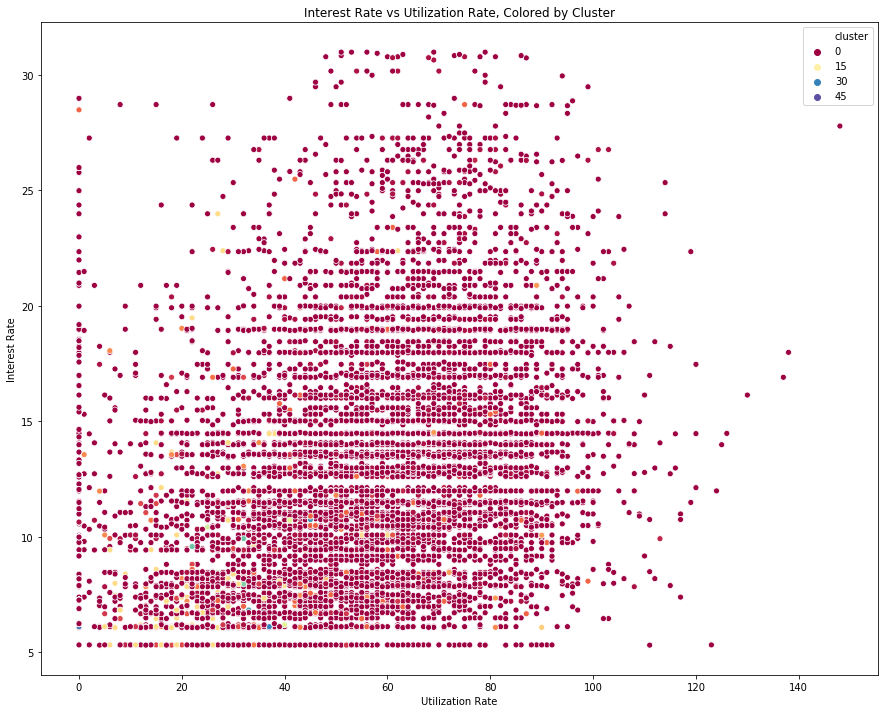

In [65]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='all_util', hue='cluster', data=trim_df, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Utilization Rate')
plt.title('Interest Rate vs Utilization Rate, Colored by Cluster')
plt.show()

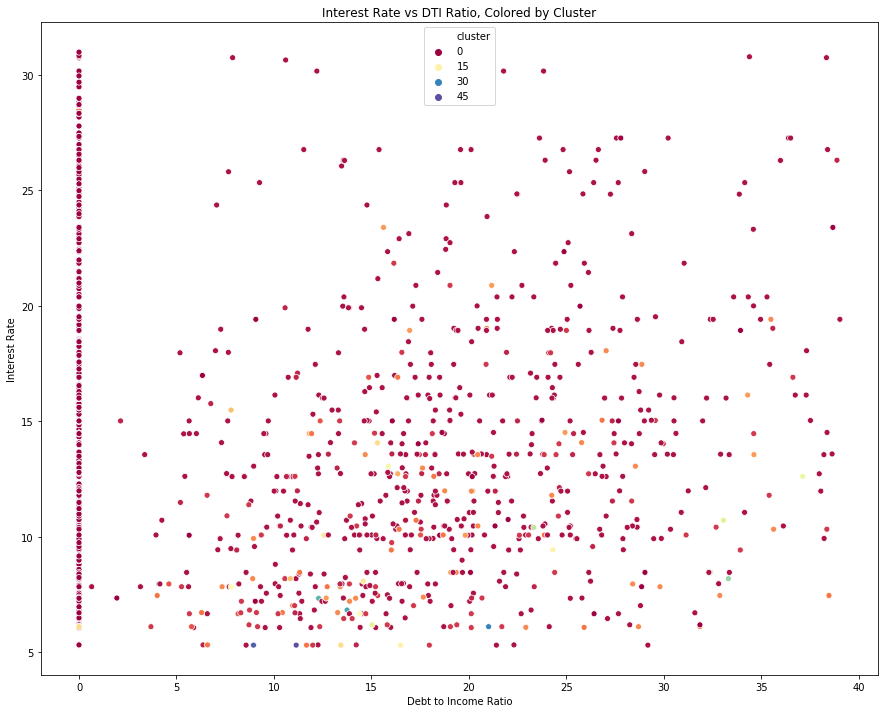

In [66]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='dti_joint', hue='cluster', data=trim_df, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Debt to Income Ratio')
plt.title('Interest Rate vs DTI Ratio, Colored by Cluster')
plt.show()



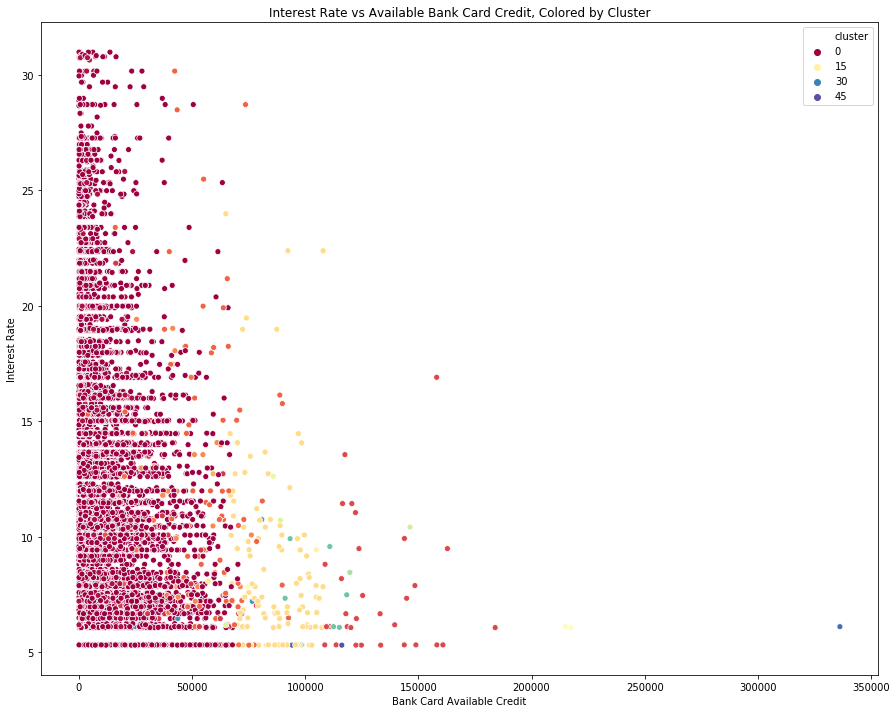

In [76]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='bc_open_to_buy', hue='cluster', data=trim_df, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Bank Card Available Credit')
plt.title('Interest Rate vs Available Bank Card Credit, Colored by Cluster')
plt.show()

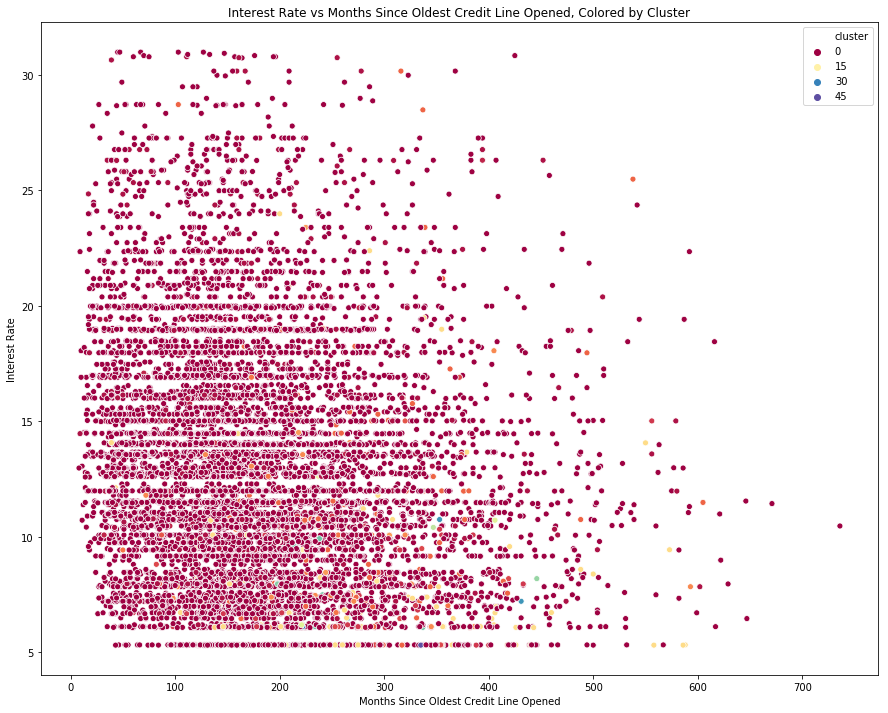

In [77]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='mo_sin_old_rev_tl_op', hue='cluster', data=trim_df, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Months Since Oldest Credit Line Opened')
plt.title('Interest Rate vs Months Since Oldest Credit Line Opened, Colored by Cluster')
plt.show()


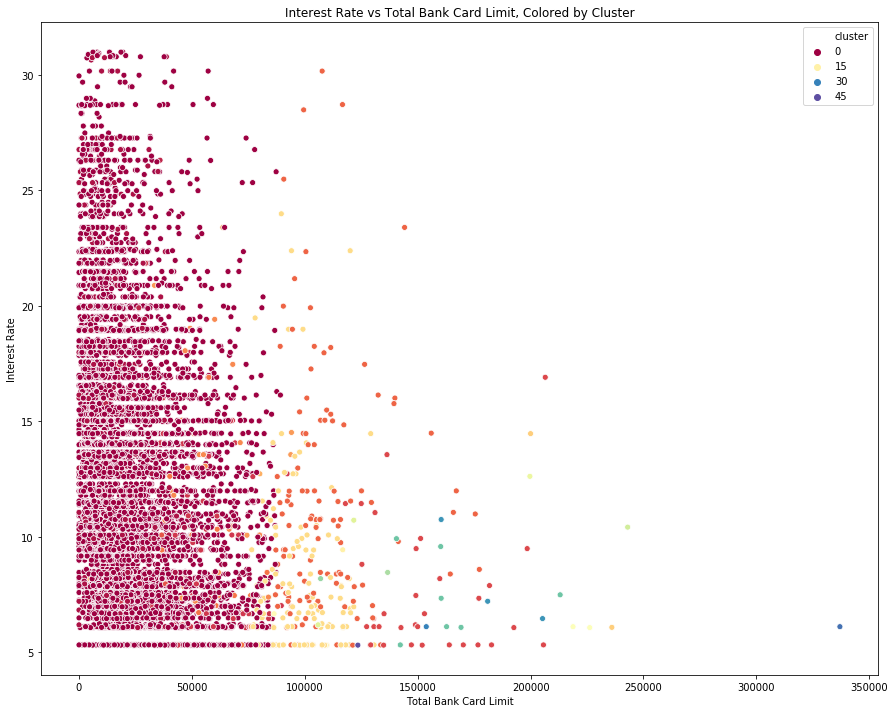

In [78]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='total_bc_limit', hue='cluster', data=trim_df, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Total Bank Card Limit')
plt.title('Interest Rate vs Total Bank Card Limit, Colored by Cluster')
plt.show()

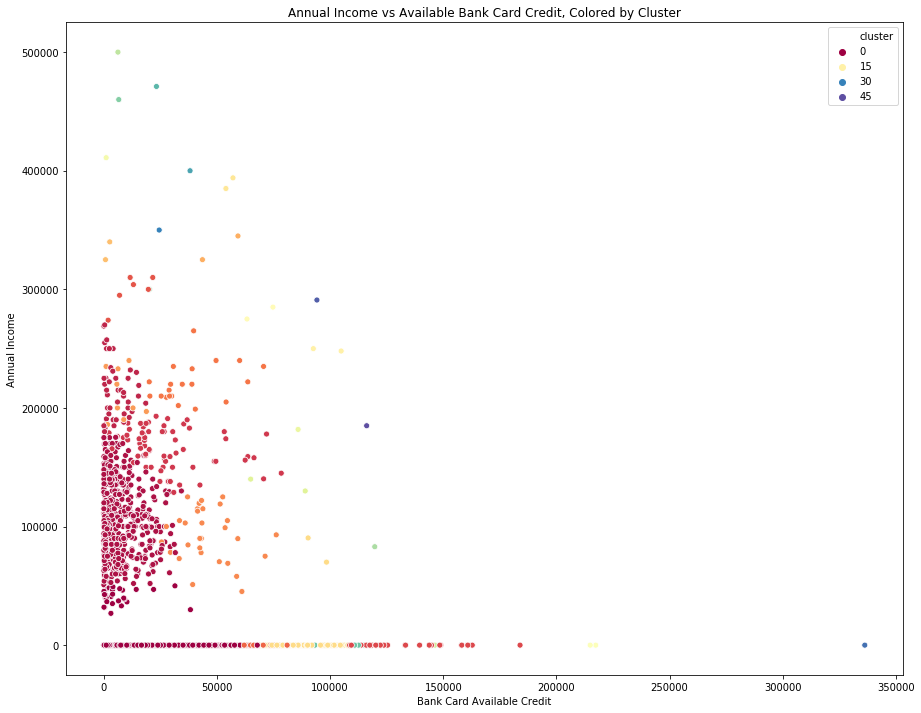

In [80]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='annual_inc_joint', x='bc_open_to_buy', hue='cluster', data=trim_df, palette='Spectral')
plt.ylabel('Annual Income')
plt.xlabel('Bank Card Available Credit')
plt.title('Annual Income vs Available Bank Card Credit, Colored by Cluster')
plt.show()

## Mean Shift 2

In [67]:
ms0 = MeanShift(bandwidth=75000, bin_seeding=True)
ms0.fit(trim_df0)

# Extract cluster assignments for each data point.
labels0 = ms0.labels_

# Coordinates of the cluster centers.
cluster_centers0 = ms0.cluster_centers_

# Count our clusters.
n_clusters_0 = len(np.unique(labels0))

print("Number of estimated clusters: {}".format(n_clusters_0))

Number of estimated clusters: 5


In [46]:
trim_df0['cluster'] = labels0

In [47]:
trim_df0.cluster.value_counts()

0    9272
1     679
3      29
2      17
4       3
Name: cluster, dtype: int64

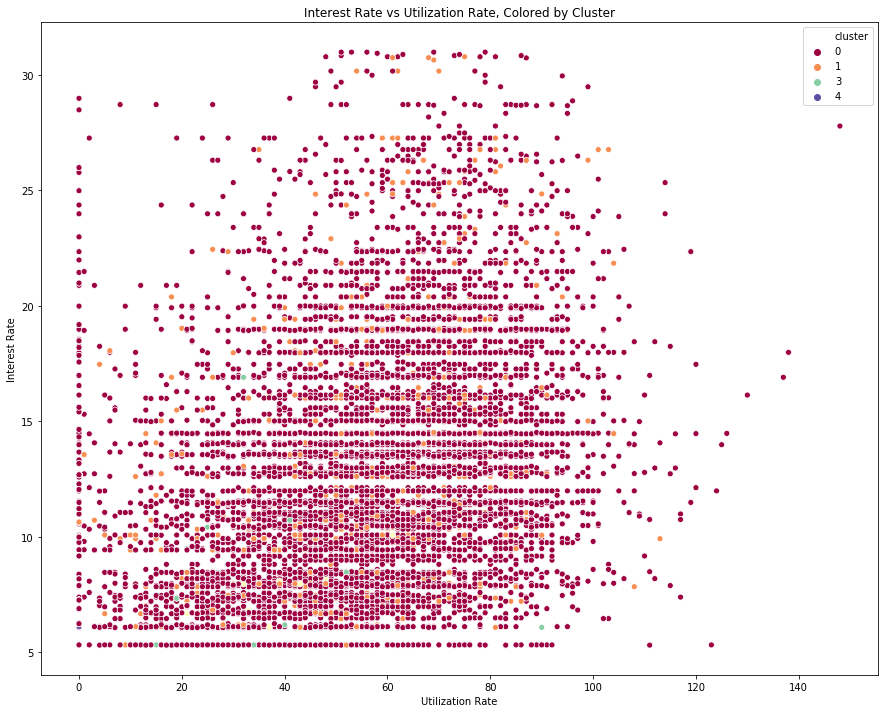

In [68]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='all_util', hue='cluster', data=trim_df0, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Utilization Rate')
plt.title('Interest Rate vs Utilization Rate, Colored by Cluster')
plt.show()

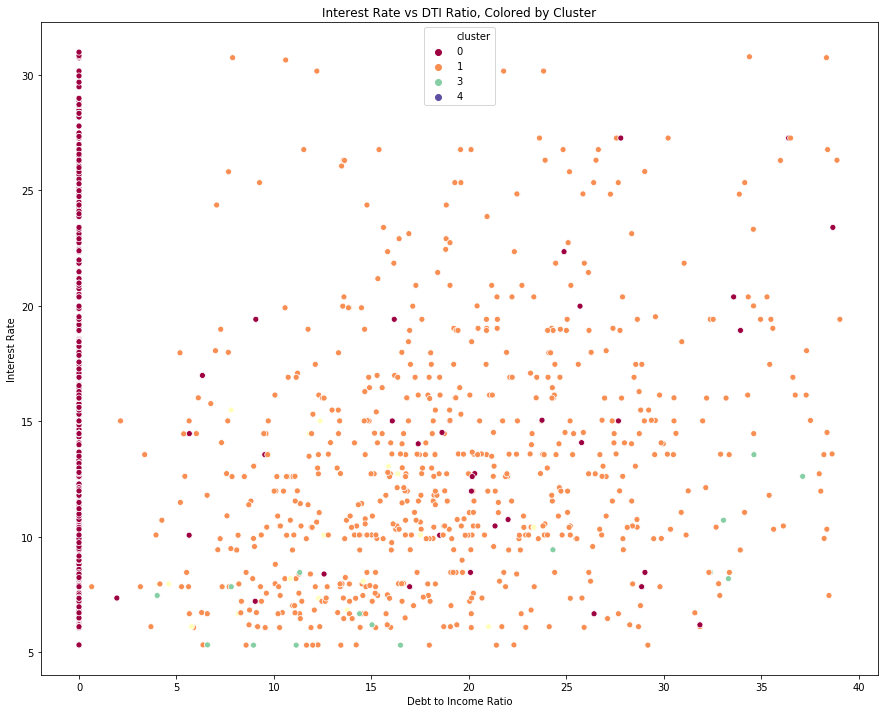

In [69]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='dti_joint', hue='cluster', data=trim_df0, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Debt to Income Ratio')
plt.title('Interest Rate vs DTI Ratio, Colored by Cluster')
plt.show()

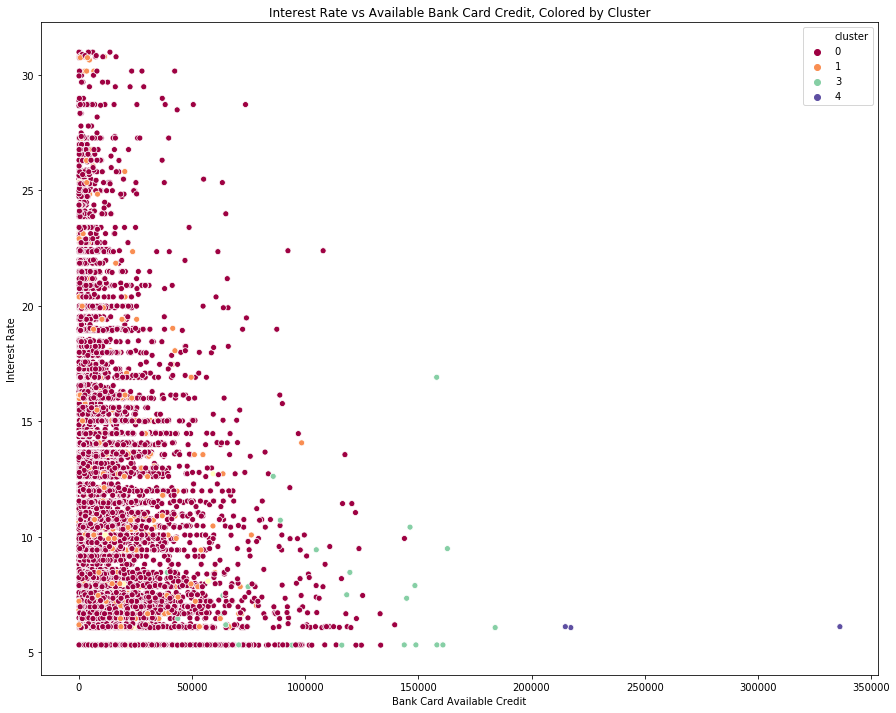

In [71]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='bc_open_to_buy', hue='cluster', data=trim_df0, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Bank Card Available Credit')
plt.title('Interest Rate vs Available Bank Card Credit, Colored by Cluster')
plt.show()

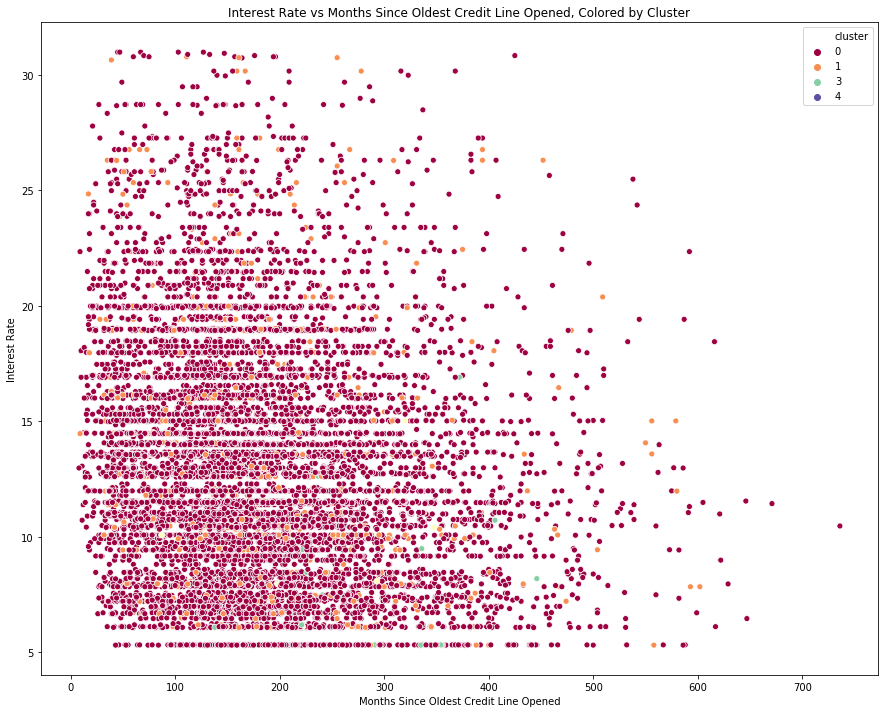

In [73]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='mo_sin_old_rev_tl_op', hue='cluster', data=trim_df0, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Months Since Oldest Credit Line Opened')
plt.title('Interest Rate vs Months Since Oldest Credit Line Opened, Colored by Cluster')
plt.show()


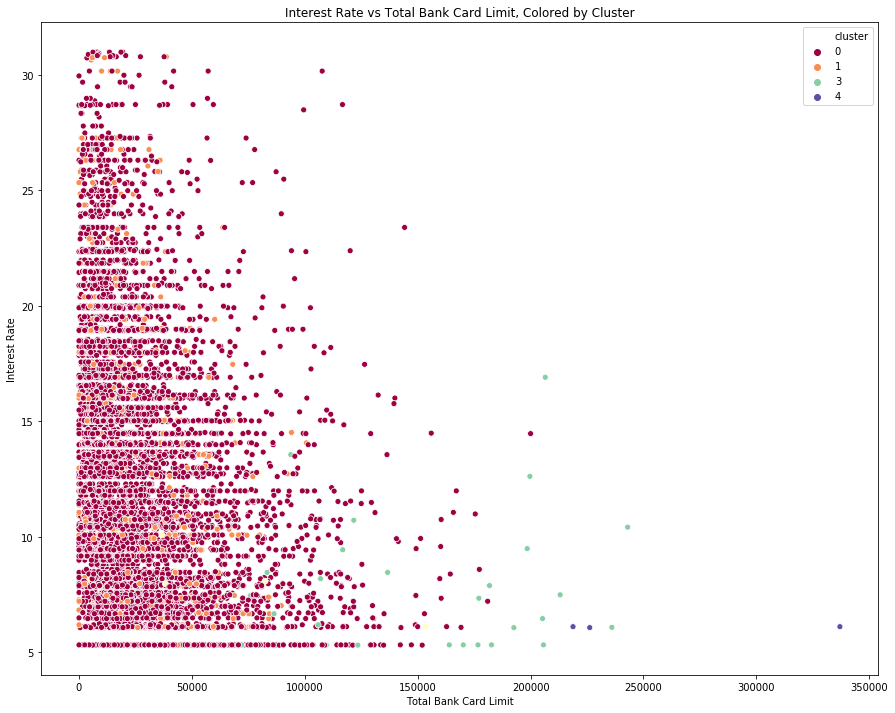

In [75]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='total_bc_limit', hue='cluster', data=trim_df0, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Total Bank Card Limit')
plt.title('Interest Rate vs Total Bank Card Limit, Colored by Cluster')
plt.show()

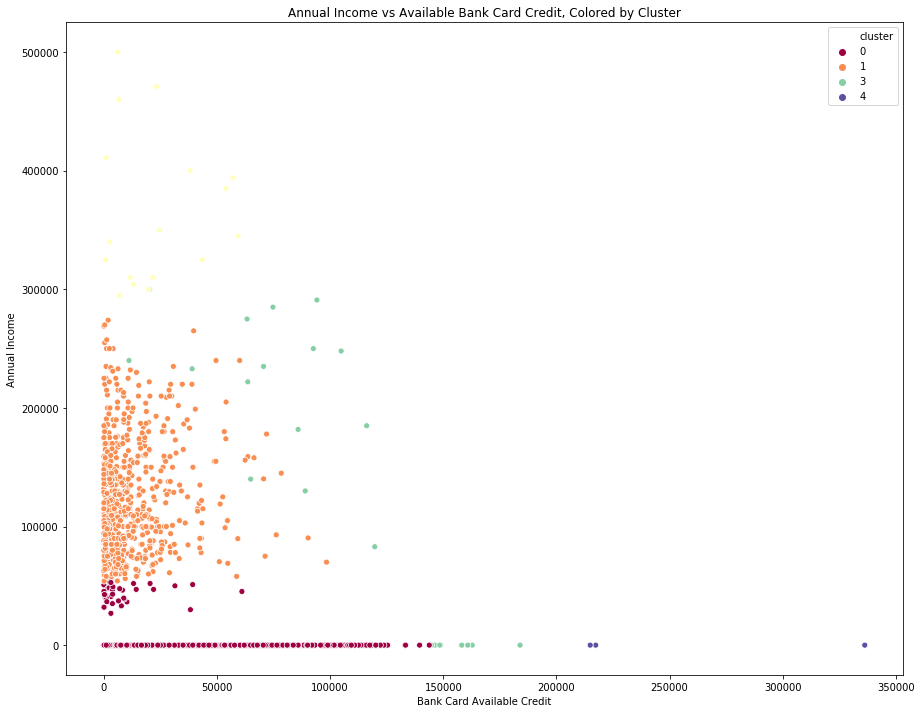

In [81]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='annual_inc_joint', x='bc_open_to_buy', hue='cluster', data=trim_df0, palette='Spectral')
plt.ylabel('Annual Income')
plt.xlabel('Bank Card Available Credit')
plt.title('Annual Income vs Available Bank Card Credit, Colored by Cluster')
plt.show()

## K-Means, K=5

In [48]:
from sklearn.cluster import KMeans

km2 = KMeans(n_clusters=5, random_state=42).fit(trim_df2)

km2_labels = km2.labels_

km2_cluster_centers = km2.cluster_centers_

In [49]:
trim_df2['cluster'] = km2_labels

In [50]:
trim_df2.cluster.value_counts()

3    6603
0    2281
2     533
4     409
1     174
Name: cluster, dtype: int64

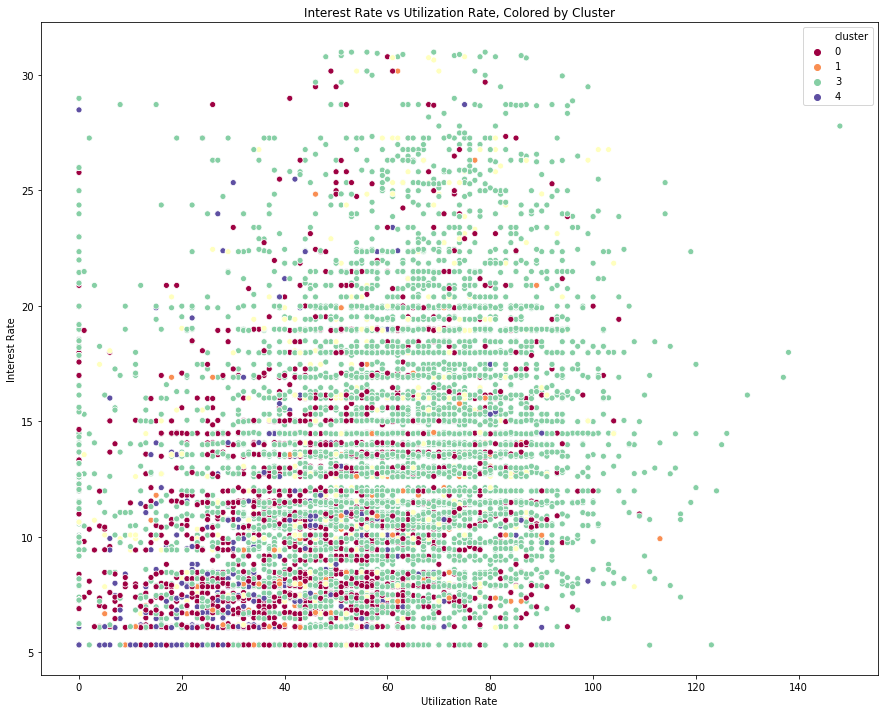

In [82]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='all_util', hue='cluster', data=trim_df2, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Utilization Rate')
plt.title('Interest Rate vs Utilization Rate, Colored by Cluster')
plt.show()

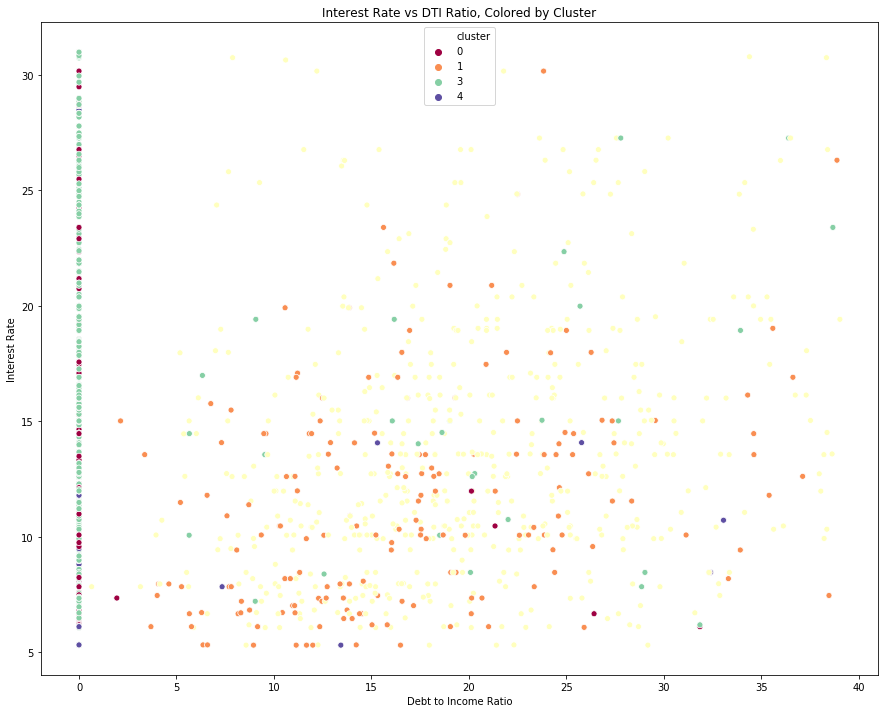

In [83]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='dti_joint', hue='cluster', data=trim_df2, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Debt to Income Ratio')
plt.title('Interest Rate vs DTI Ratio, Colored by Cluster')
plt.show()

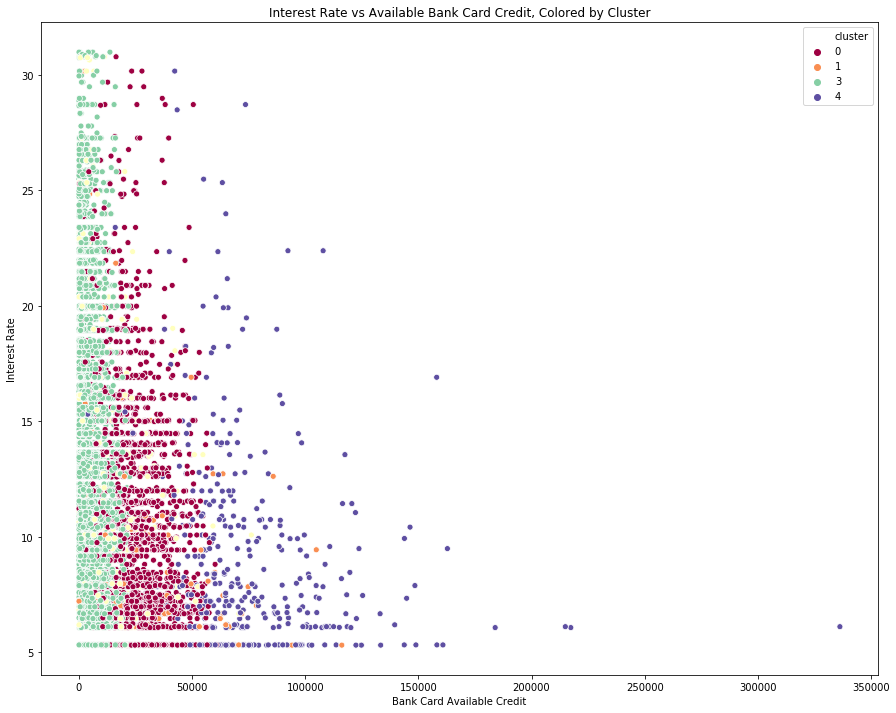

In [84]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='bc_open_to_buy', hue='cluster', data=trim_df2, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Bank Card Available Credit')
plt.title('Interest Rate vs Available Bank Card Credit, Colored by Cluster')
plt.show()

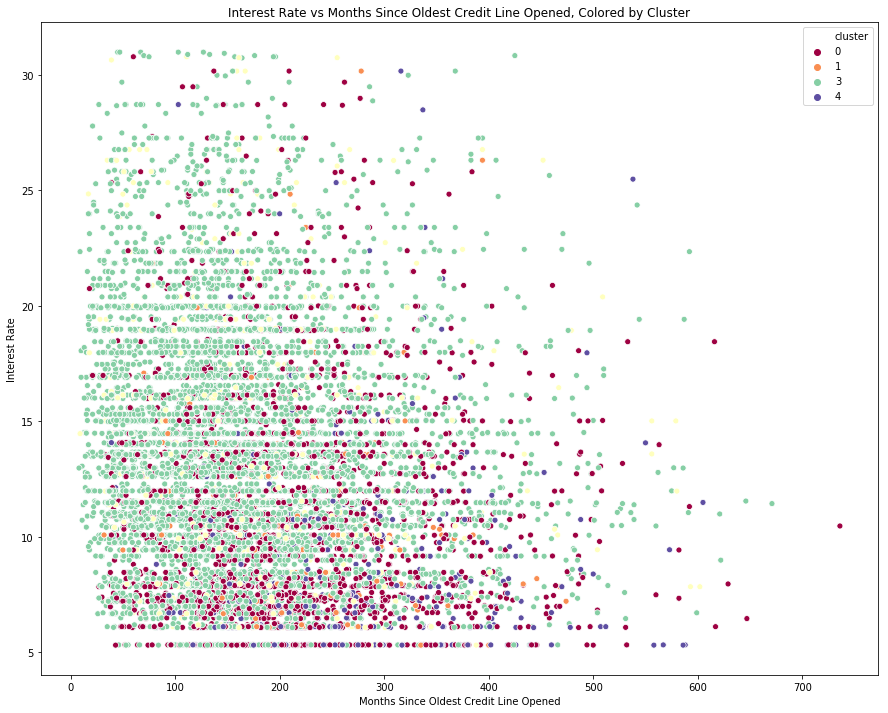

In [85]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='mo_sin_old_rev_tl_op', hue='cluster', data=trim_df2, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Months Since Oldest Credit Line Opened')
plt.title('Interest Rate vs Months Since Oldest Credit Line Opened, Colored by Cluster')
plt.show()

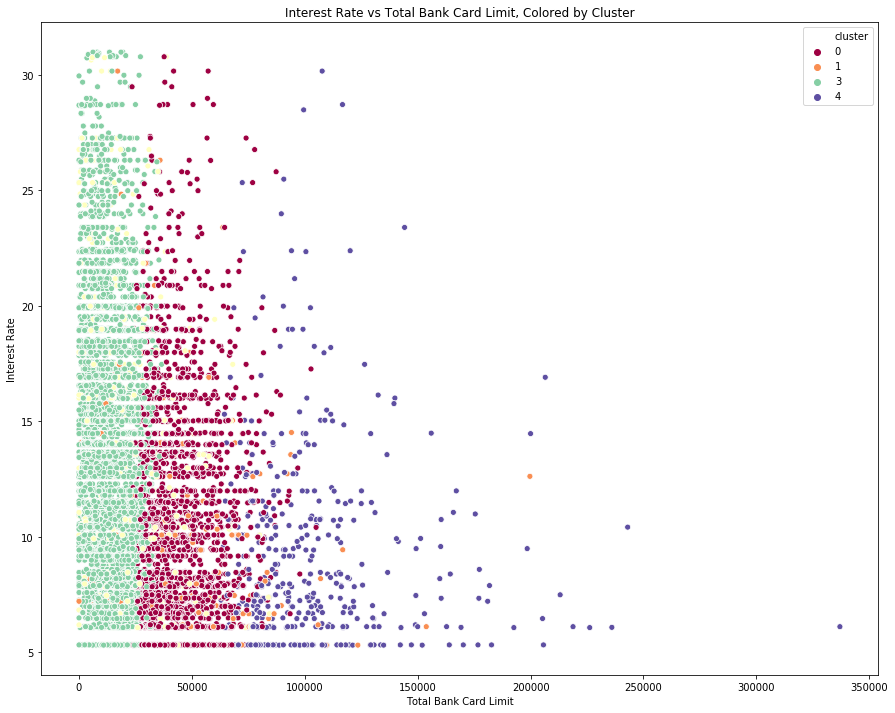

In [86]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='total_bc_limit', hue='cluster', data=trim_df2, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Total Bank Card Limit')
plt.title('Interest Rate vs Total Bank Card Limit, Colored by Cluster')
plt.show()

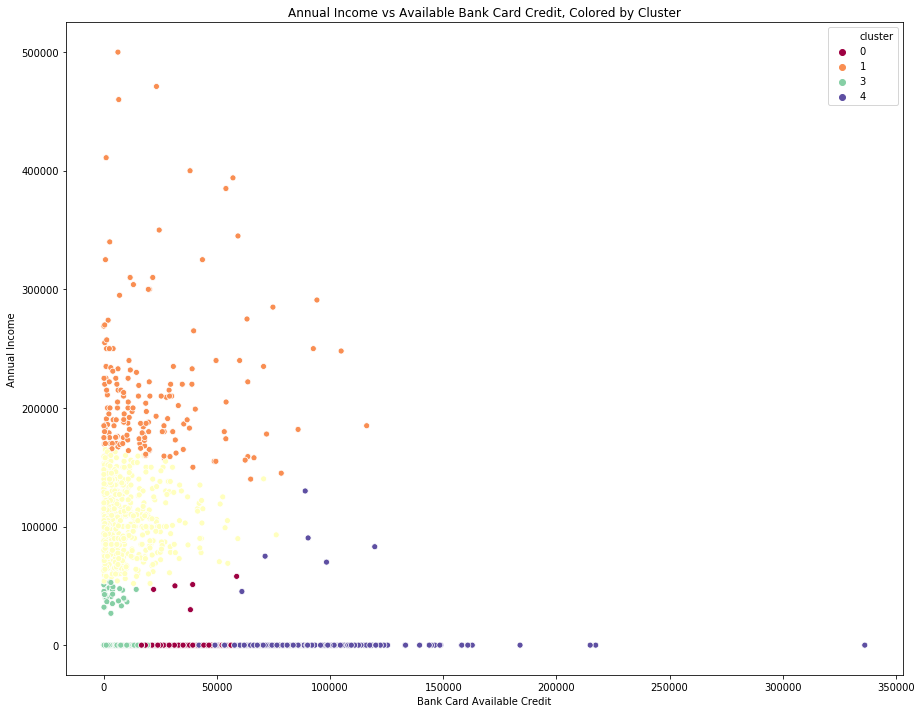

In [87]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='annual_inc_joint', x='bc_open_to_buy', hue='cluster', data=trim_df2, palette='Spectral')
plt.ylabel('Annual Income')
plt.xlabel('Bank Card Available Credit')
plt.title('Annual Income vs Available Bank Card Credit, Colored by Cluster')
plt.show()

## K-Means, K=12

In [53]:
from sklearn.cluster import KMeans

km3 = KMeans(n_clusters=12, random_state=42).fit(trim_df3)

km3_labels = km3.labels_

km3_cluster_centers = km3.cluster_centers_

In [54]:
trim_df3['cluster'] = km3_labels

In [55]:
trim_df3.cluster.value_counts()

0     4182
9     2648
3     1325
8      526
5      358
10     285
1      254
2      208
4      115
7       53
11      25
6       21
Name: cluster, dtype: int64

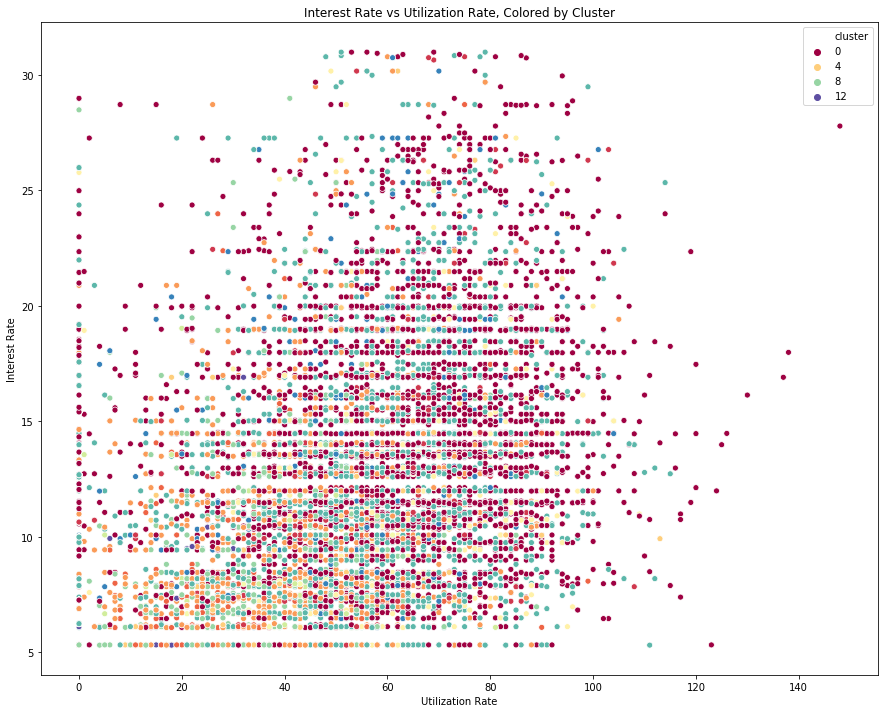

In [88]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='all_util', hue='cluster', data=trim_df3, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Utilization Rate')
plt.title('Interest Rate vs Utilization Rate, Colored by Cluster')
plt.show()

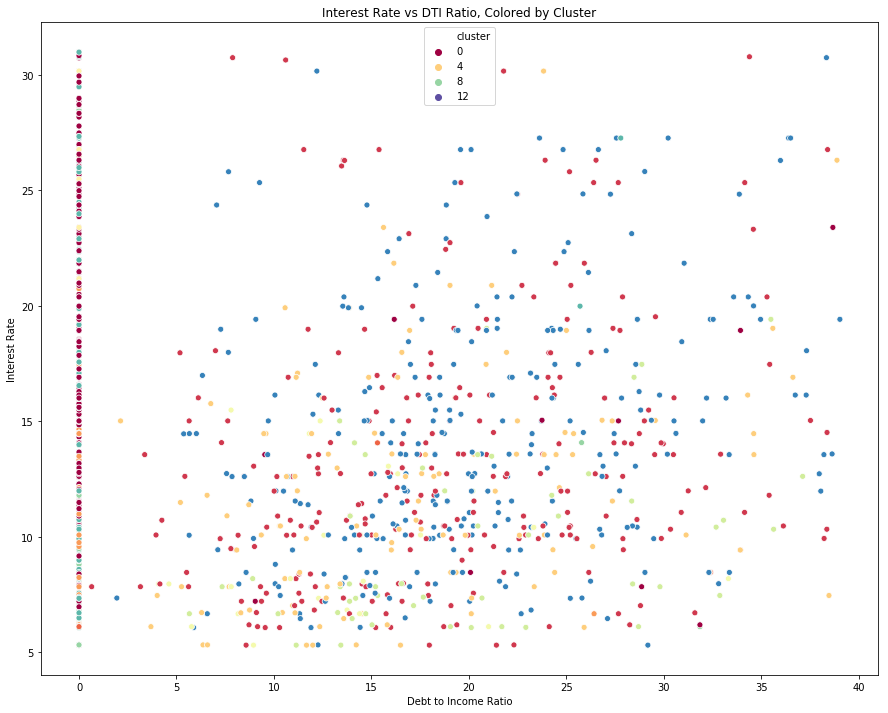

In [89]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='dti_joint', hue='cluster', data=trim_df3, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Debt to Income Ratio')
plt.title('Interest Rate vs DTI Ratio, Colored by Cluster')
plt.show()

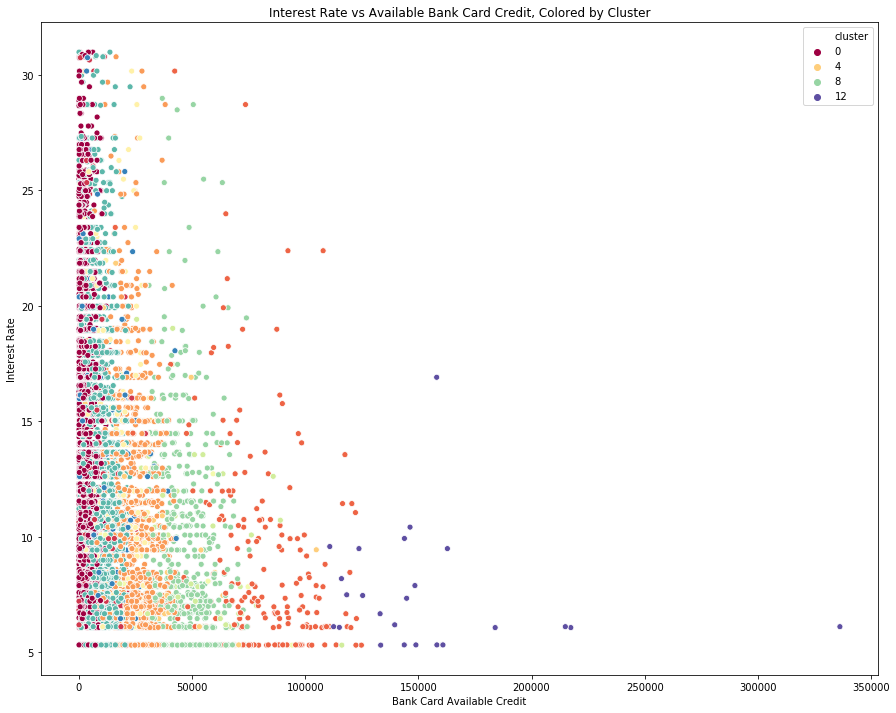

In [90]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='bc_open_to_buy', hue='cluster', data=trim_df3, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Bank Card Available Credit')
plt.title('Interest Rate vs Available Bank Card Credit, Colored by Cluster')
plt.show()

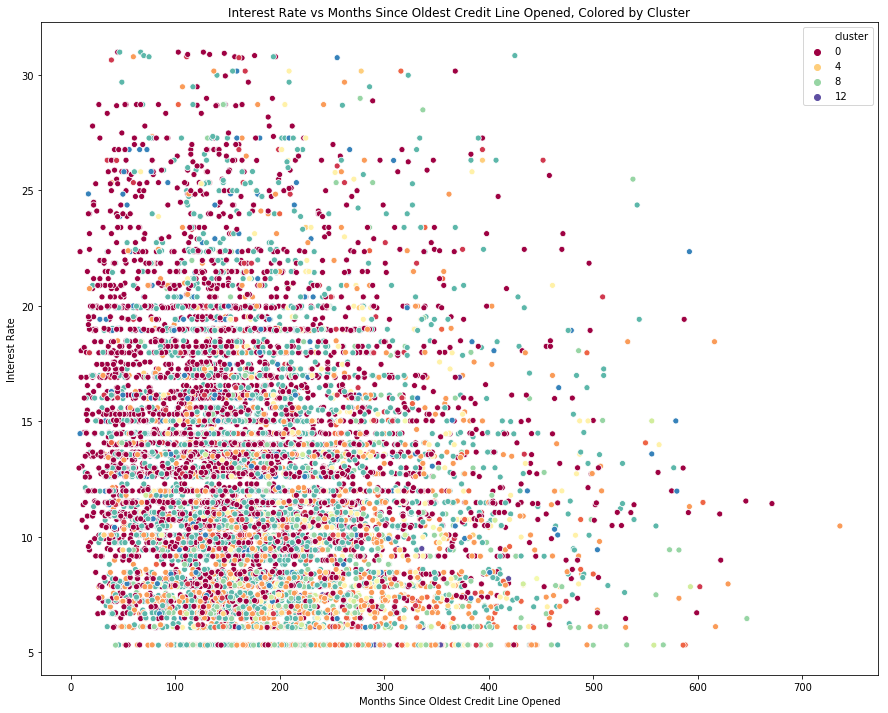

In [91]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='mo_sin_old_rev_tl_op', hue='cluster', data=trim_df3, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Months Since Oldest Credit Line Opened')
plt.title('Interest Rate vs Months Since Oldest Credit Line Opened, Colored by Cluster')
plt.show()

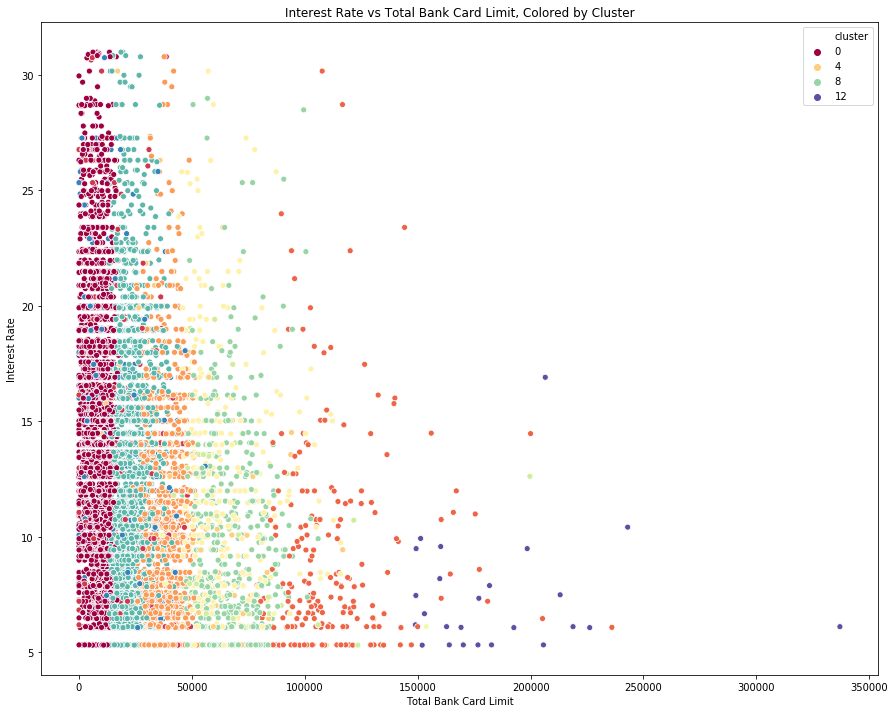

In [92]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='total_bc_limit', hue='cluster', data=trim_df3, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Total Bank Card Limit')
plt.title('Interest Rate vs Total Bank Card Limit, Colored by Cluster')
plt.show()

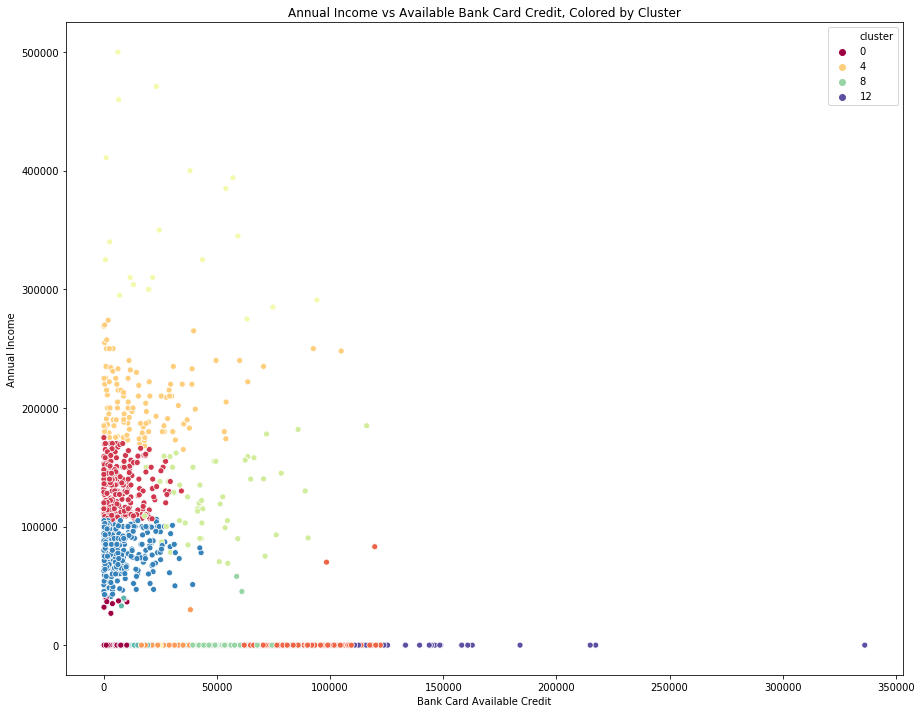

In [93]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='annual_inc_joint', x='bc_open_to_buy', hue='cluster', data=trim_df3, palette='Spectral')
plt.ylabel('Annual Income')
plt.xlabel('Bank Card Available Credit')
plt.title('Annual Income vs Available Bank Card Credit, Colored by Cluster')
plt.show()

## K-Means, K=20

In [57]:
from sklearn.cluster import KMeans

km4 = KMeans(n_clusters=20, random_state=42).fit(trim_df4)

km4_labels = km4.labels_

km4_cluster_centers = km4.cluster_centers_

In [58]:
trim_df4['cluster'] = km4_labels

In [59]:
trim_df4.cluster.value_counts()

0     2861
14    2332
6     1125
9     1114
15     599
1      472
7      329
13     234
16     175
5      159
2      158
18     150
8       94
4       78
11      54
3       17
10      15
17      15
19      11
12       8
Name: cluster, dtype: int64

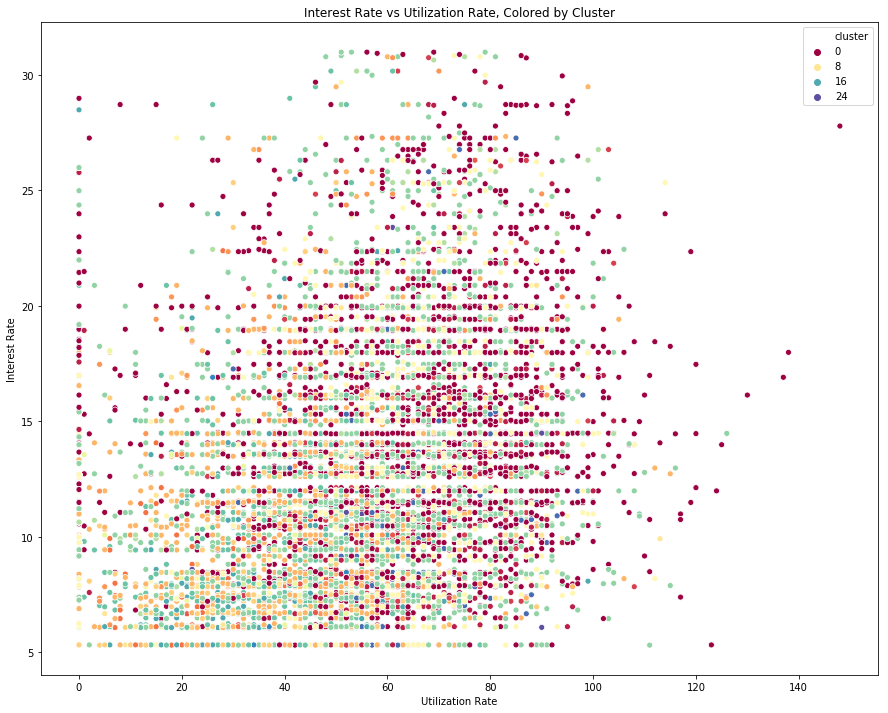

In [94]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='all_util', hue='cluster', data=trim_df4, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Utilization Rate')
plt.title('Interest Rate vs Utilization Rate, Colored by Cluster')
plt.show()

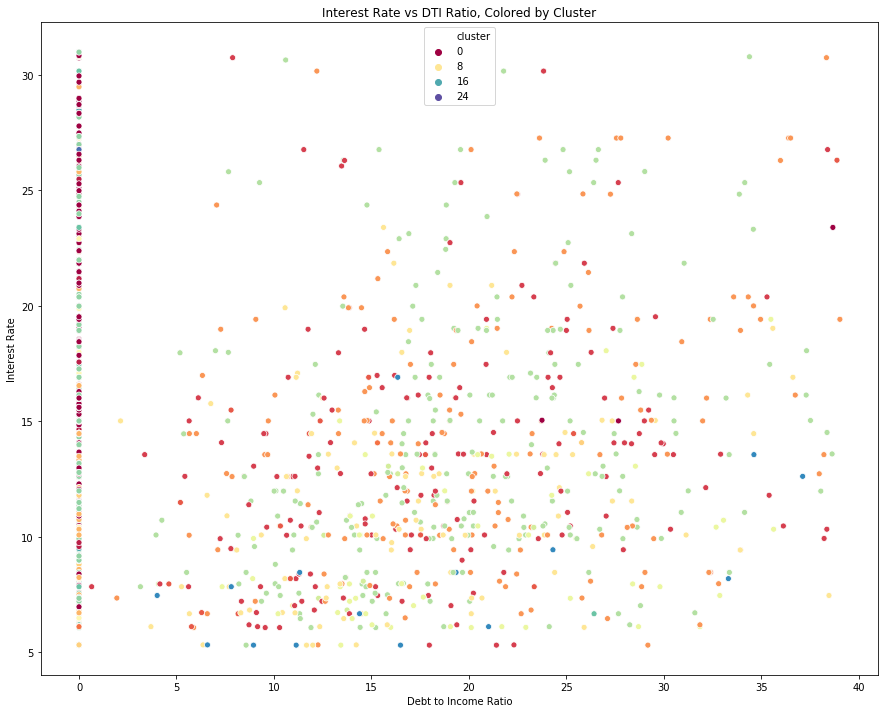

In [95]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='dti_joint', hue='cluster', data=trim_df4, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Debt to Income Ratio')
plt.title('Interest Rate vs DTI Ratio, Colored by Cluster')
plt.show()

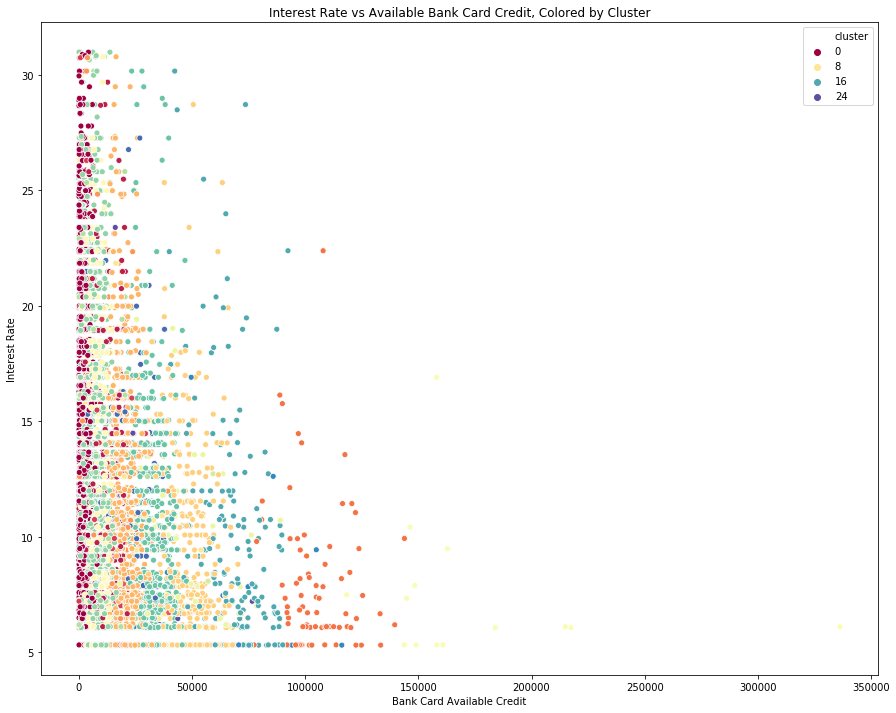

In [96]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='bc_open_to_buy', hue='cluster', data=trim_df4, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Bank Card Available Credit')
plt.title('Interest Rate vs Available Bank Card Credit, Colored by Cluster')
plt.show()

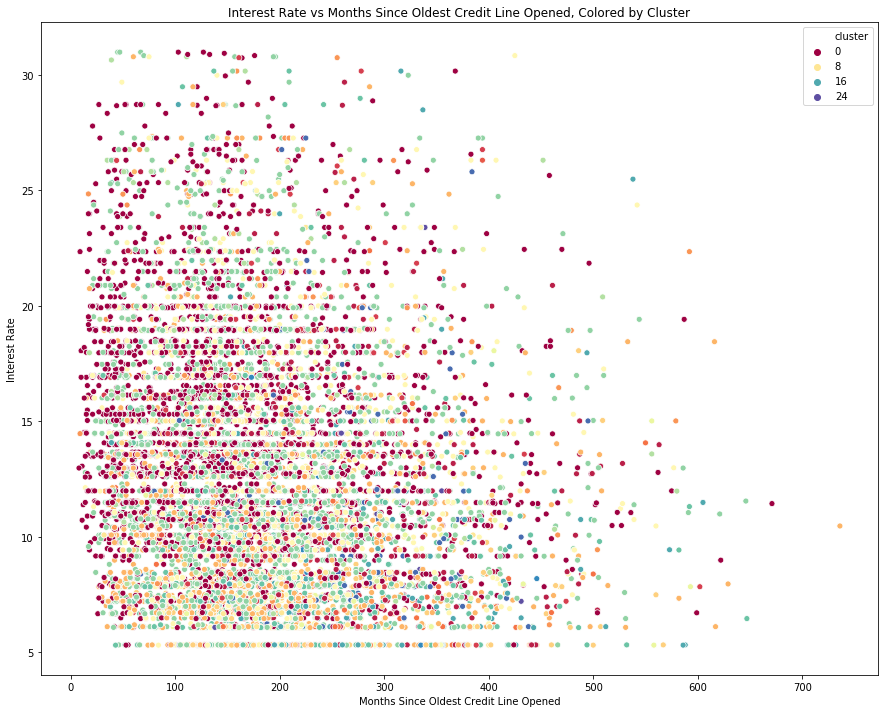

In [98]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='mo_sin_old_rev_tl_op', hue='cluster', data=trim_df4, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Months Since Oldest Credit Line Opened')
plt.title('Interest Rate vs Months Since Oldest Credit Line Opened, Colored by Cluster')
plt.show()

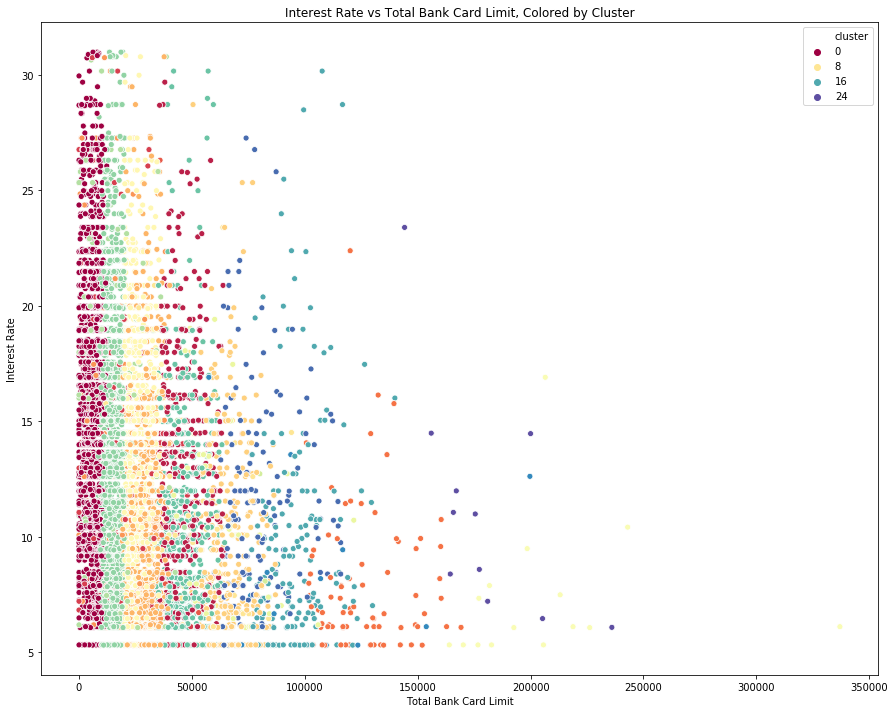

In [99]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='int_rate', x='total_bc_limit', hue='cluster', data=trim_df4, palette='Spectral')
plt.ylabel('Interest Rate')
plt.xlabel('Total Bank Card Limit')
plt.title('Interest Rate vs Total Bank Card Limit, Colored by Cluster')
plt.show()

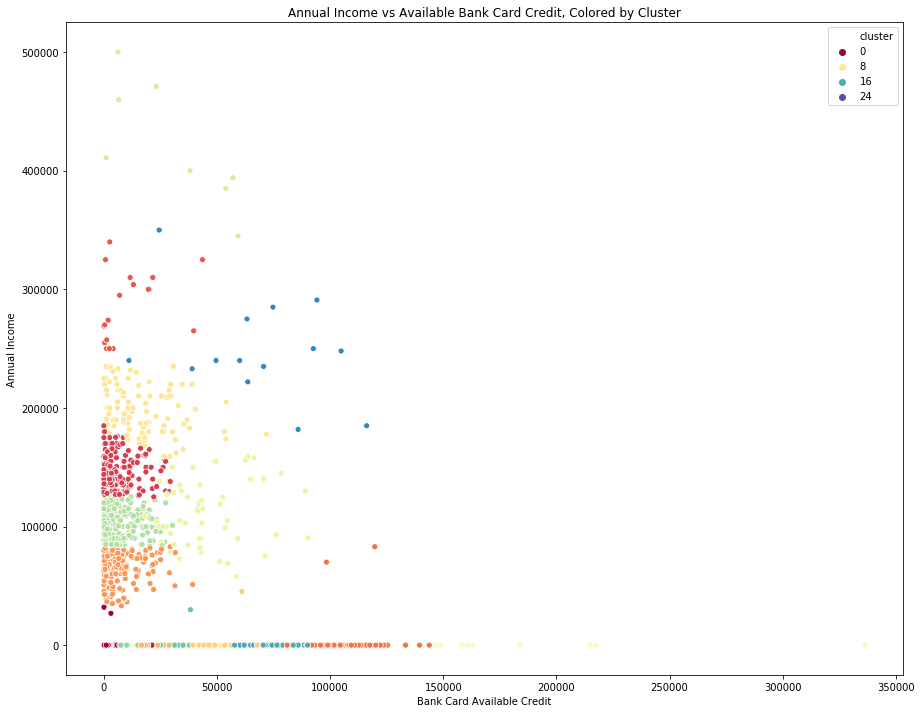

In [100]:
plt.figure(figsize = (15,12))
sns.scatterplot(y='annual_inc_joint', x='bc_open_to_buy', hue='cluster', data=trim_df4, palette='Spectral')
plt.ylabel('Annual Income')
plt.xlabel('Bank Card Available Credit')
plt.title('Annual Income vs Available Bank Card Credit, Colored by Cluster')
plt.show()